In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("한글 폰트 세팅 완료")

한글 폰트 세팅 완료


In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import gzip

print(tf.__version__)

2.6.0


In [ ]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [3]:
# 데이터 살펴보기
file_dir = os.getcwd() + '/korean-english-park.train.tar.gz'

with gzip.open(file_dir, 'rt') as f:
    raw = f.read().splitlines()
    
print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 188247
Example:
>> korean-english-park.train.en                                                                        000644  000765  000024  00055552615 12360160402 016155  0                                                                                                    ustar 00pj                              staff                           000000  000000                                                                                                                                                                         Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive pr

In [4]:
mid = len(raw) // 2 # 한국어와 영어 텍스트의 경계
print(raw[:3])
print(raw[mid: mid + 3])

['korean-english-park.train.en\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00000644 \x00000765 \x00000024 \x0000055552615 12360160402 016155\x00 0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ustar\x0000pj\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00staff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [5]:
# 리스트를 한국어 문장인 키와 영어 문장인 값으로 분리
# 데이터의 형태: ['영어', '영어', ... '한국어', '한국어']

keys =  raw[mid:]  # 뒤 쪽 절반인 한국어 부분  
values = raw[:mid] # 앞 쪽 절반인 영어부분

# zip() 함수와 dict() 함수를 사용하여 딕셔너리 생성
dictionary = dict(zip(keys, values))

print("딕셔너리 크기:",len(dictionary))

딕셔너리 크기: 77591


In [6]:
# 딕셔너리 내에 값의 중복을 제거하는 함수

def remove_duplicate_values(original_dict):
    # 값을 키로, 키를 값으로 하는 임시 딕셔너리 생성
    temp_dict = {val: key for key, val in original_dict.items()}
    # 다시 원래 형태로 변환하여 중복 제거된 딕셔너리 생성
    result_dict = {val: key for key, val in temp_dict.items()}
    return result_dict


unique_dict = remove_duplicate_values(dictionary)
len(unique_dict)

74832

In [7]:
# 딕셔너리 매핑 확인하기
print(list(unique_dict.items())[10], end='\n\n')
print(list(unique_dict.items())[11], end='\n\n')
print(list(unique_dict.items())[12], end='\n\n')

('약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌다.', 'A similar dose of caffeine, about 200-600 mg, also appears effective in enhancing physical endurance and may be especially useful in returning some of the physical endurance lost at high altitude, the study found.')

('의약 연구소는 정부에 과학 문제에 관해 자문하기 위해 의회가 설립 인가를 내어 준 민간 단체인 국립 과학 학회의 부속 단체이다.', 'The Institute of Medicine is part of the National Academy of Sciences, a private organization chartered by Congress to advise the government on scientific matters.')

('아시아에서의 왕성한 수요 덕분에 일본의 수출이 9월에 연속 6개월간 증가하여, 무역 흑자가 1조550억엔(84억7,000만달러)으로 늘어났다고 재무성이 발표했다.', 'thanks to robust demand in Asia, boosting the trade surplus to 1.055 trillion yen ($8.47 billion), the Ministry of Finance said.')



In [8]:
cleaned_corpus = list(unique_dict.items())
len(cleaned_corpus)

74832

In [9]:
# 한국어와 영어 텍스트 분리하기
kor_text = []
eng_text = []

for sentence in cleaned_corpus:
    kor_text.append(sentence[0])
    eng_text.append(sentence[1])
    

print("한국어 텍스트 길이:", len(kor_text))
print("영어 텍스트 길이:", len(eng_text))    
print()
    
# 분리된 내용 확인하기
for k, e in zip(kor_text[55:61], eng_text[55:61]):
    print(k)
    print(e)
    print()

한국어 텍스트 길이: 74832
영어 텍스트 길이: 74832

중국이 604억달러의 비용이 소요되는 아마도 세계 에서 가장 값비싼 계획 중의 하나이며, 중국 역사상 가장 규모가 큰 수로 변경 계획을 밝혔다.
China has unveiled plans for the largest water-diversion in its history and possibly one of the world's most expensive at $60.4 billion.

이 사업은 중국에서 가장 긴 강인 양쯔강의 물을 강 유역이 말라 들어가고 있는 북부의 황허, 화이허, 그리고 하이허, 세 개의 강으로 돌리게 될 것이다.
The project will channel water from the country's longest river, the Yangtze, to three rivers in the north, the Yellow, Huai and Hai, whose basins are running dry.

이 야심찬 남북 수로 변경 사업은 더 습하고 홍수가 잦은 남부의 강 유역을 매우 건조한 북부 지방과 연결시키는 세 개의 수로를 따라 물을 이동시키게 될 것이다.
The ambitious South-to-North Water Transfer Project will move water along three channels linking the wetter flood-prone southern basin to parched northern climes.

최근의 사업 중에는 3개의 협곡 수력 발전 댐, 4,000킬로미터의 천연 가스 파이프라인 계획, 그리고 큉하이에서 티벳까지의 세계 최고도의 철로 건설이 포함되어 있다.
This is just one of the latest of China's massive public works projects, recent ones including the Three Gorges hydroelectric dam, a proposed 4,00

## 데이터 정제하기

In [10]:
import re

def preprocess_sentence(sentence, language='en', s_token=False, e_token=False):
    # 앞뒤 공백 제거
    sentence = sentence.strip()

    # 영어의 경우 소문자로 변환
    if language == 'en':
        sentence = sentence.lower()

    # 구두점 주위에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 연속된 공백을 하나의 공백으로 대체
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 언어에 따라 적절한 문자만 유지
    if language == 'en':
        # 영문자, 숫자, 특정 특수문자만 유지
        sentence = re.sub(r"[^a-zA-Z0-9?.!,]+", " ", sentence)
    elif language == 'ko':
        # 한글, 숫자, 특정 특수문자만 유지
        sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
    else:
        raise ValueError("Unsupported language. Use 'en' for English or 'ko' for Korean.")

    # 앞뒤 공백 다시 제거
    sentence = sentence.strip()

    # 시작 토큰 추가 (옵션)
    if s_token:
        sentence = '<start> ' + sentence

    # 종료 토큰 추가 (옵션)
    if e_token:
        sentence += ' <end>'
    
    return sentence


In [11]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

# 한국어 텍스트 전처리
for text in kor_text[:num_examples]:
    enc_corpus.append(preprocess_sentence(text, language='ko'))

# 영어 텍스트 전처리
for text in eng_text[:num_examples]:
    dec_corpus.append(preprocess_sentence(text, language='en', s_token=True, e_token=True))    
    

# 전처리된 내용 확인하기
for enc, dec in zip(enc_corpus[100:105], dec_corpus[100:105]):
    print(enc)
    print(dec)
    print() 

1 , 960만갤론 이상의 중유를 운반하던 손상된 유조선이 스페인 북서부 연안 130마일 해역에서 침몰하여 , 스페인 당국이 어업이 주요 산업인 이 지역에서 해안선 보호를 위해 황급히 서두르고 있다 .
<start> carrying more than 19 . 6 million gallons of heavy fuel oil sank 130 miles off spain s northwest coast , leaving spanish authorities scrambling to protect the coastline in the region where fishing is the primary industry . <end>

싣고 있는 기름이 모두 유출된다면 , 알라스카 프린스 윌리암 사운드에서 1989년에 발생했던 엑손 발데즈 기름 유출 사건의 규모보다 두 배 이상이 되는 사상 최대 규모의 기름 유출 사건 중의 하나가 될 것이라고 세계 야생 생물 기금이 경고하고 있다 .
<start> the world wildlife fund warns that if all of the oil leaked , it would be one of the largest oil spills ever more than twice the size of the 1989 exxon valdez spill in alaska s prince william sound . <end>

대도시를 완전히 파괴할 만큼 커다란 우주의 암석 덩어리들이 지구에 충돌하는 것은 이전에 생각했던 것보다 빈도가 훨씬 적은 , 대략 1천년에 한 번 정도이다 .
<start> space boulders big enough to wipe out a major city slam into the earth about once every 1 , 000 years , much less frequently than previously thought . <end>

핵폭발의 근거지를 찾아내는 국방성의 인공위성으로부터 얻은 수년간의 자

## 데이터 전처리: 토큰화

In [12]:
num_words = 20000
oov_token = '<unk>'
maxlen=50

In [13]:
def eng_tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

    return tensor, tokenizer

In [14]:
from konlpy.tag import Mecab
def kor_tokenize(corpus):
    mecab = Mecab()
    tokenized_corpus = [" ".join(mecab.morphs(sentence)) for sentence in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

    return tensor, tokenizer

In [15]:
enc_tensors, enc_tokenizer = eng_tokenize(enc_corpus)
dec_tensors, dec_tokenizer = kor_tokenize(dec_corpus)
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensors, dec_tensors, test_size = 0.2, random_state = 42)

In [16]:
print(enc_train.shape)
print(dec_train.shape)
print(enc_train[:5])
print()
print(dec_tensors[:5])

(24000, 50)
(24000, 50)
[[    1     1  5257  1194  3136   101 12424     1     1  2017     1   776
      1 17681     1    60     2     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [ 5352  7373  5353     9   141    33   654     1     7     2     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [   27   850     1     1    26 12908     3  9244  5214   116  1000     1
   9135     1  3403     1     1   343  6691     2     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [  266 11728  4117 14243   495    37  9880

## 모델 설계

In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [20]:
# 코드를 실행하세요.

BATCH_SIZE     = 16
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512  
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (16, 30, 512)
Decoder Output: (16, 31433)
Decoder Hidden State: (16, 512)
Attention: (16, 30, 1)


## 훈련하기

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [22]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [ ]:
from tqdm import tqdm    # tqdm
import random

In [23]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 1500/1500 [04:37<00:00,  5.41it/s, Loss 3.7882]


In [ ]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

In [28]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: . .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_139/2860932276.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_139/2860932276.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


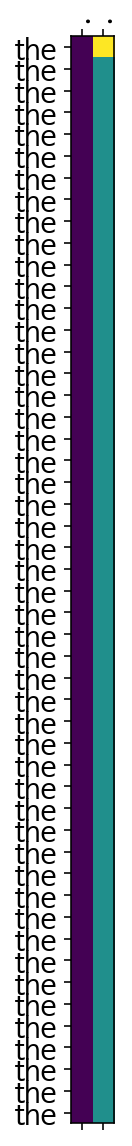

In [29]:
translate("안녕하세요. 만나서 반갑습니다.", encoder, decoder)

Input: .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_139/2860932276.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_139/2860932276.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


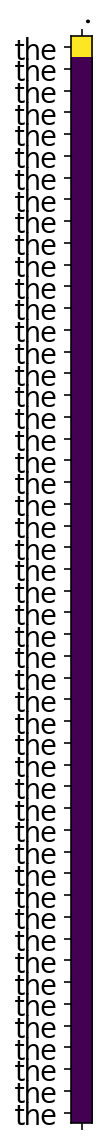

In [30]:
translate("이 야심찬 남북 수로 변경 사업은 더 습하고 홍수가 잦은 남부의 강 유역을 매우 건조한 북부 지방과 연결시키는 세 개의 수로를 따라 물을 이동시키게 될 것이다.", encoder, decoder)